**Изучение алгоритма "Решающее дерево"**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import sklearn.tree as tree
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import cross_val_score,\
                                    train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_breast_cancer

import graphviz

# Источники

1. <a href="https://hastie.su.domains/ISLR2/ISLRv2_website.pdf">ISLR</a> страница 336;
2. <a href="https://scikit-learn.org/stable/modules/tree.html#tree-regression">User guide от sklearn</a>;
3. <a href="https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html">Алгоритм обрезки с учётом сложности затрат в sklearn;</a>
4. <a href="https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py">Пример использования алгоритма обрезки с учётом сложности затрат от sklearn</a>;

# Идея группы методов

Решающим деревом можно решать как задачи регрессии так и классификации. Идея в том, что исходное пространтсво предикторов разбивается на обаласти ($R_1, R_2, ... , R_m$) и на каждой области $R_i$ предсказывается значение зависящее от наблюдений в ней.

Например для задачи регрессии можно предсказывать среднее значение отклика для выбранной области. Так в следующем примере представлено как может быть сформировано решеющее дерево для данных соответсвующий параболоиду.

Граф сверху описывает принцип принятия решений, рисунки снизу указывают как формировались предсказания.

- звенья графа в которых происходит решение называются **внутренние узлы (internal nodes)**;
- звенья графа которые формирут конечный результат и соответсвуют $R_i$ называеются **конечные узлы или листики (terminal nodes)**.

### *Задача регрессии*

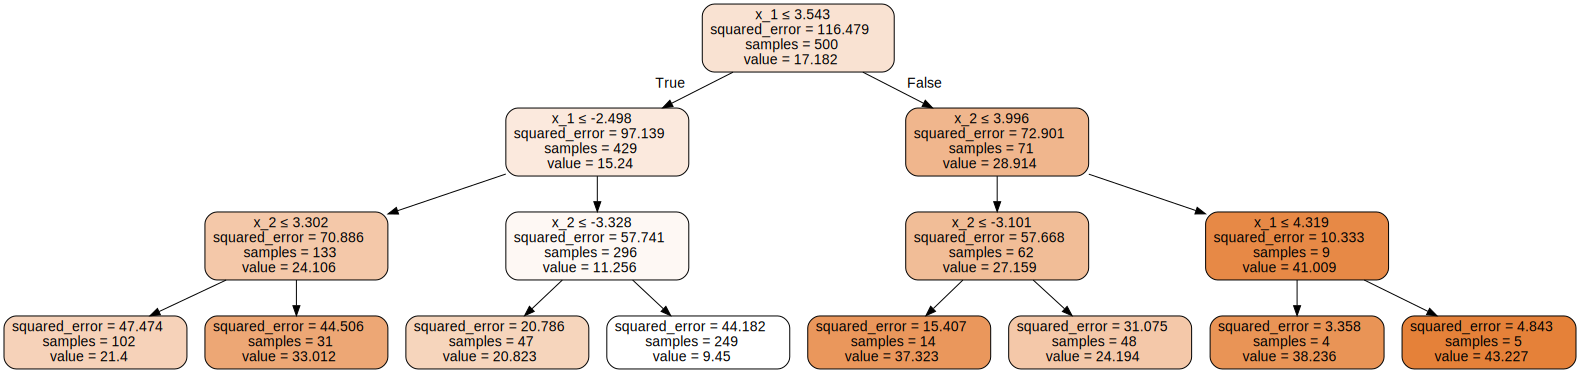

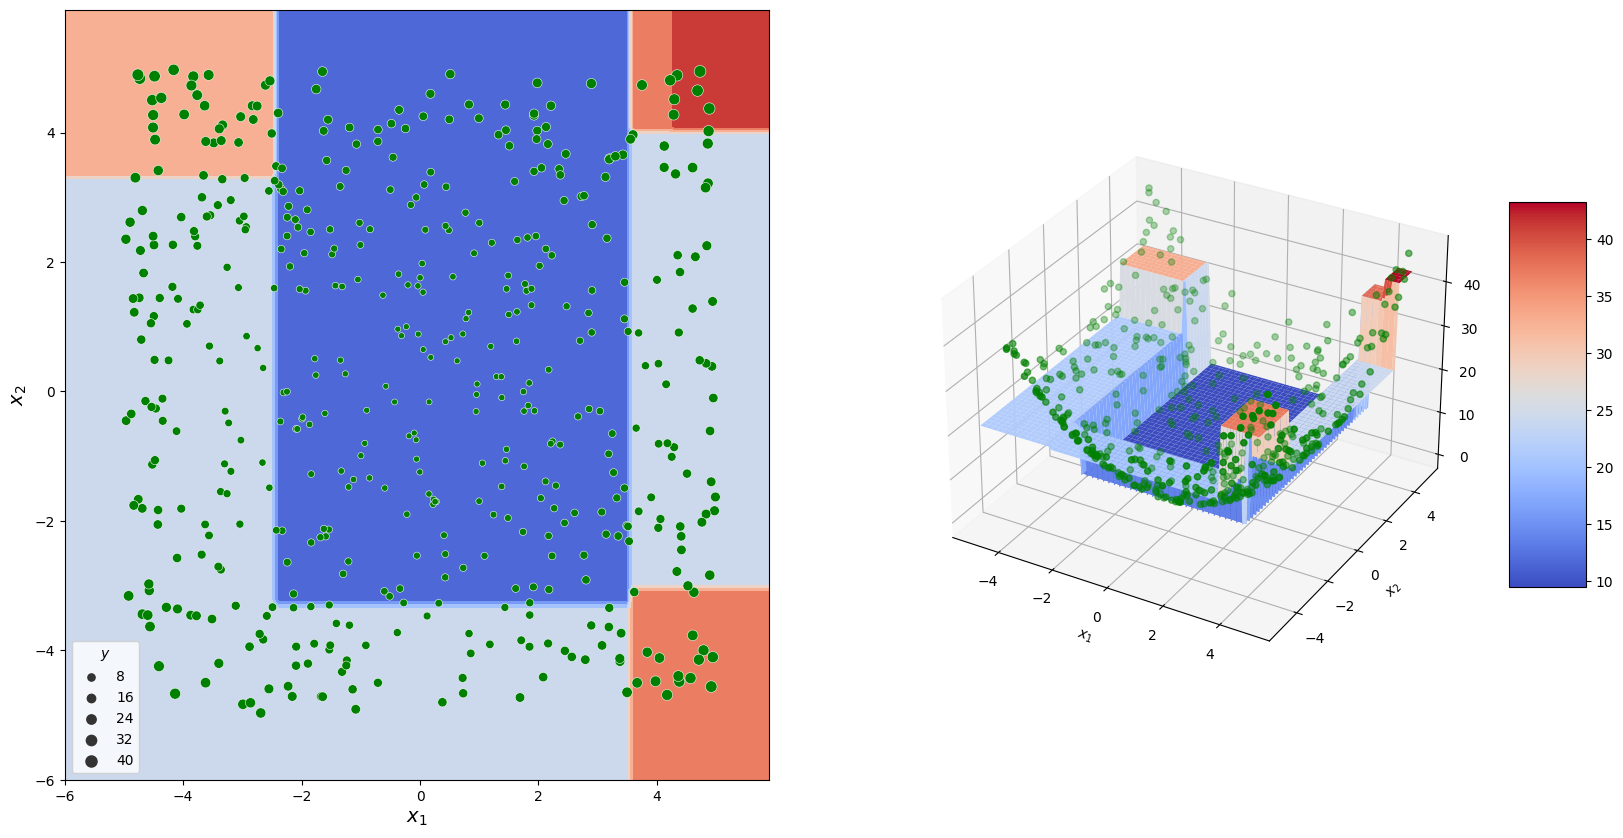

In [2]:
# подготовка обучающей выборки
sample_size = 500
np.random.seed(30)

x1_lim = [-5, 5]
x2_lim = [-5, 5]

sample_df = pd.DataFrame({
    "$x_1$" : np.random.uniform(*x1_lim, sample_size),
    "$x_2$" : np.random.uniform(*x2_lim, sample_size),
})

sample_df["$y$"] = sample_df["$x_1$"]**2 + sample_df["$x_2$"]**2

# формирование модели
my_first_tree = tree.DecisionTreeRegressor(\
    max_depth = 3
).fit(
    sample_df[["$x_1$", "$x_2$"]],
    sample_df["$y$"]
)

# сетка предстказаний
x1_range = np.arange(*x1_lim, 0.1)
x2_range = np.arange(*x2_lim, 0.1)
x1_mesh, x2_mesh = np.meshgrid(x1_range, x2_range)

mesh_df = pd.DataFrame({
    "$x_1$" : x1_mesh.ravel(),
    "$x_2$" : x2_mesh.ravel()
})
p_mesh = np.reshape(
    my_first_tree.predict(mesh_df),
    x1_mesh.shape
)

# визуализация
dot_data = tree.export_graphviz(
    my_first_tree, out_file=None,
    feature_names = ["x_1", "x_2"],
    filled=True, rounded=True,  
    special_characters=True
)
graph = graphviz.Source(dot_data)
display(graph)

fig = plt.figure(figsize = [20, 10])

ax1 = fig.add_subplot(121)
DecisionBoundaryDisplay.from_estimator(
    my_first_tree,
    mesh_df,
    cmap=cm.coolwarm,
    response_method="predict",
    ax = ax1,
)
sns.scatterplot(
    data = sample_df,
    x = "$x_1$", y = "$x_2$",
    size = "$y$",
    ax=ax1,
    color = "green"
)
plt.xlabel("$x_1$", fontsize = 14)
plt.ylabel("$x_2$", fontsize = 14)

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(
    sample_df["$x_1$"],
    sample_df["$x_2$"],
    sample_df["$y$"],
    color = "green"
)
surf = ax2.plot_surface(
    x1_mesh, x2_mesh, p_mesh,
    cmap=cm.coolwarm
)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.xlabel("$x_1$"); plt.ylabel("$x_2$");

### Задача классификации

Идея та же - бинарное деление пространтсва предикоторов максимизируя некоторую статистику. Отдельного внимания заслуживают эти статистики:

- *Индекс GINI*:

$$G = \sum_{k =1}^K \hat{p}_{mk}(1-\hat{p}_{mk});$$

где $\hat{p}_{mk}$ - доля наблюдений $k$ класса принадлежащих региону  $m$;

Интерестно, что в данном случае получается что чем ближе доли $\hat{p}_{mk}$ к нулю или единице (что в данном случае хорошо), тем меньше будет индекс GINI. Пока не до конца понятно как именно происходит минимизация - похоже подбирается такое отсечение, чтобы GINI был миниматен в любой из получаемых после отсечения областей.

- *Энтропия*

$$D = -\sum_{k=1}^{K}\hat{p}_{mk}log(\hat{p}_{mk})$$

Обладает очень похожими свойствами с индексом GINI.

# Обрезка дерева

Очевидно, что слишком глубокие деревья ведут к переобучению а недостаточно глубокие к низкой гибкости модели. В результате требуется подобрать такую глибину дерева, чтобы подобрать опитимальный компромисс между дисперсией и смещением. Для того можно пробовать:

1. Идеальном случае следовало бы провести кроссвалидацию для дерева любой длинны и выбрать ту, что на кроссвалидации выдает наилучшие результаты;
2. В [1] предлагают использовать **алгоритм "обрезки с учетом сложности затрат" (cost complexity pruning)**.

### Алгоритм "обрезки с учетом сложности затрат"

Алгоритм предполагает использование целевой функции:

$$\sum_{m=1}^{|T|}\sum_{x_i \in R_m}(y_i-\hat{y}_{R_m})^2+\alpha|T|\rightarrow min$$

Модель кроссвалидируется при разных $\alpha$. Соответсвенно подбирается оптимальный параметр $\alpha$. По сути это эквивалентно регуляризации модели.

#### **SKLearn**

Пример представленный в докумментации sklearn. Основная фишка в том, что sklearn может найти эффективные $\alpha$ для каждого звена. То есть такие $\alpha$, при которых отбрасывается следущее звено за ненадобностью (то есть эффект от $\alpha|T|$ выше чем влияние узла на результат на тренировочной выборке).

В `sklearn` предзожен метод  `tree.DecisionTreeClassifier.cost_complexity_pruning_path`. Она возвращаяет те  после которых отбрасывается листик. Кроме того, можно получить соответствующую суммарную примесь листьев на каждом этапе процесса обрезки (total impurity of leaves). Так далее представлен гарфик, на котором показано, как с ростом $\alpha$ все больше и больше лисьев оказываются отброщенными.

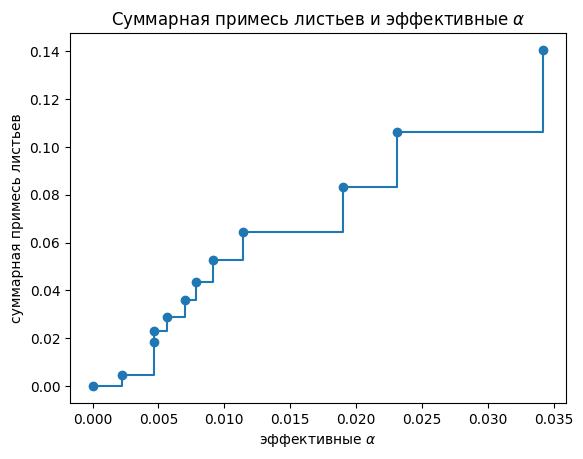

In [3]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = tree.DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("эффективные $\\alpha$")
ax.set_ylabel("суммарная примесь листьев")
ans = ax.set_title("Суммарная примесь листьев и эффективные $\\alpha$")

Следующий пример учит модели на эффективных $\alpha$ и представляет как с увеличением $\alpha$ уменьшаяется гибкость модели - мельше листьев и глубины. Вплоть до одного узла.

Этот пример я вставил больше потому, что полезно знать как извлекать длинну глубину и число узлов полученного дерева:
- `tree.DecisionTreeClassifier.tree_.max_depth`;
- `tree.DecisionTreeClassifier.tree_.node_count`.

Number of nodes in the last tree is: 1 with ccp_alpha: 0.3272984419327777


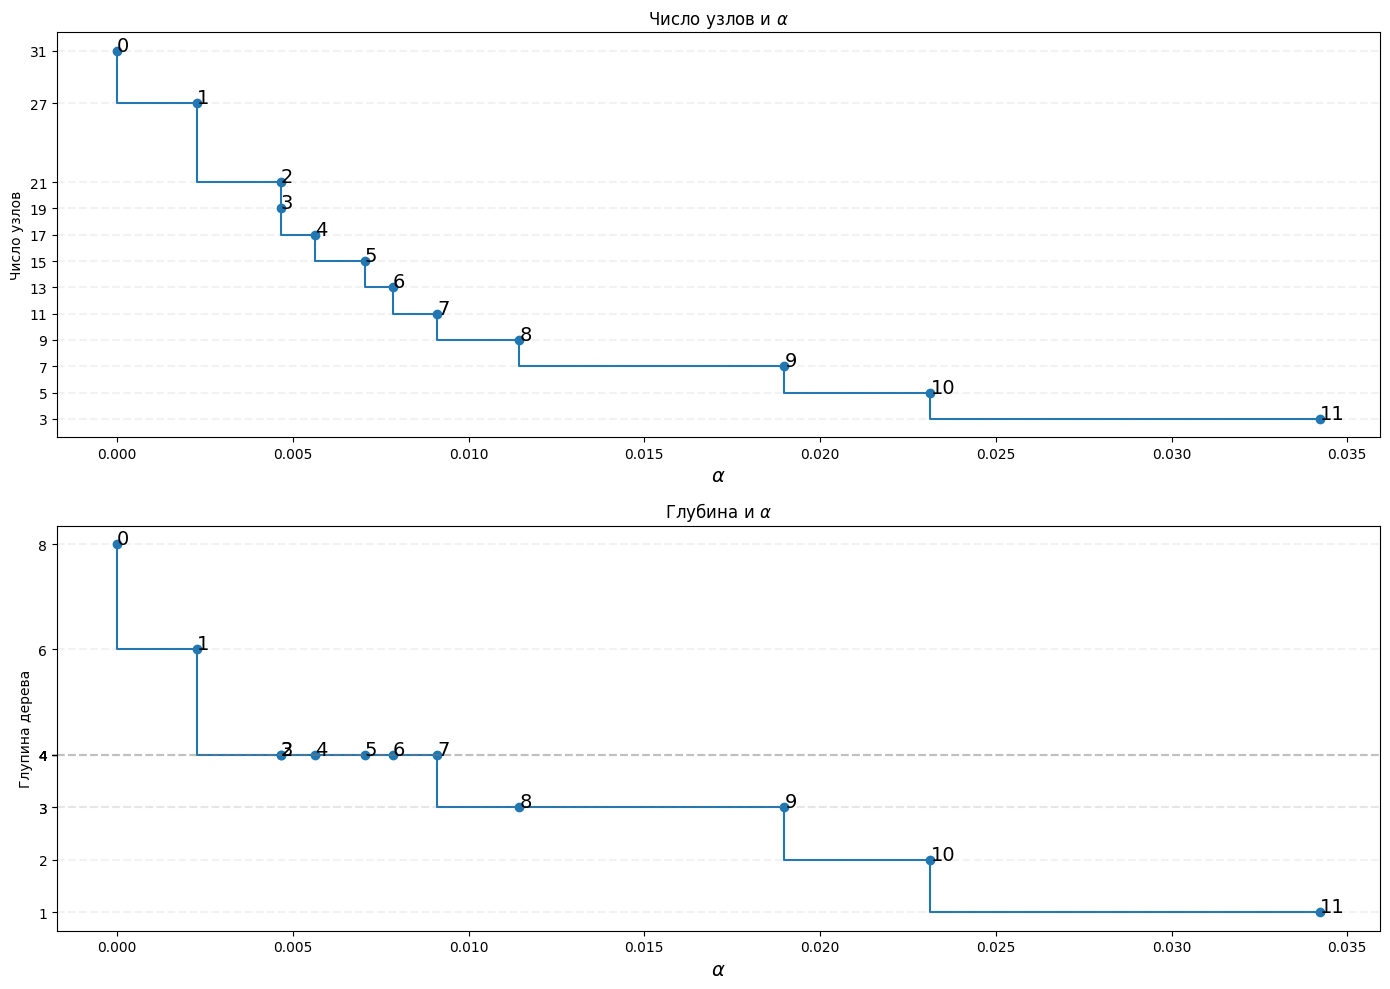

In [4]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depthes = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize = [14, 10])
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-pre")
ax[0].set_xlabel("$\\alpha$", fontsize = 14)
ax[0].set_ylabel("Число узлов")
ax[0].set_title("Число узлов и $\\alpha$")
ax[1].plot(ccp_alphas, depthes, marker="o", drawstyle="steps-pre")
ax[1].set_xlabel("$\\alpha$", fontsize = 14)
ax[1].set_ylabel("Глупина дерева")
ax[1].set_title("Глубина и $\\alpha$")
fig.tight_layout()

for i, (alpha, node_count, depth) in enumerate(zip(
    ccp_alphas, node_counts, depthes
)):
    ax[0].text(alpha, node_count, i, fontsize = 14)
    ax[0].axhline(node_count, color = "gray", linestyle = "dashed",alpha = 0.1)
    ax[1].text(alpha, depth, i, fontsize = 14)
    ax[1].axhline(depth, color = "gray", linestyle = "dashed",alpha = 0.1)

ax[0].set_yticks(node_counts)
ans = ax[1].set_yticks(depthes)

Для того, что-бы убедиться во всем описанно я решил нарисовать графы для деревьев соответсвующие 7-й и 8-й точкам. Чтобы проследить как исчезает лишний уровень глубины дерева.

Alpha = 0.009114019793328328


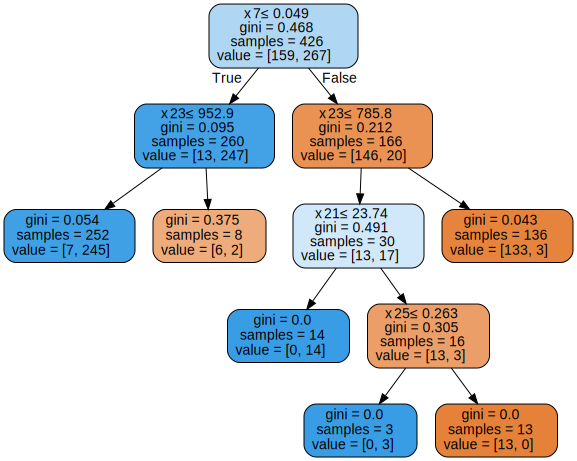

Alpha = 0.011443661971830986


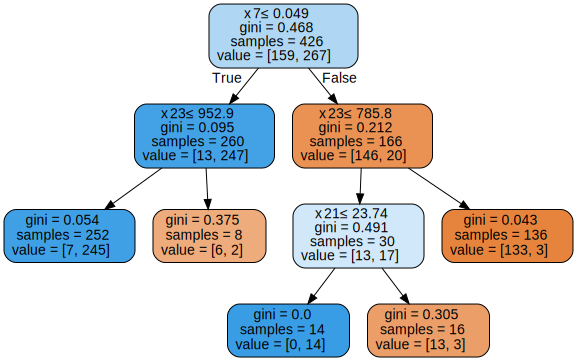

In [5]:
# визуализация
def plot_my_tree(clf):

    dot_data = tree.export_graphviz(
        clf, out_file=None,
        filled=True, rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    display(graph)

print("Alpha =", ccp_alphas[7])
plot_my_tree(clfs[7])
print("Alpha =", ccp_alphas[8])
plot_my_tree(clfs[8])


Далее продолжается исследование баланса между дисперсией и смещением. В следующем примере показано как растёт точность предсказаний на тестовой выборке с увеличением параметра $\alpha$.

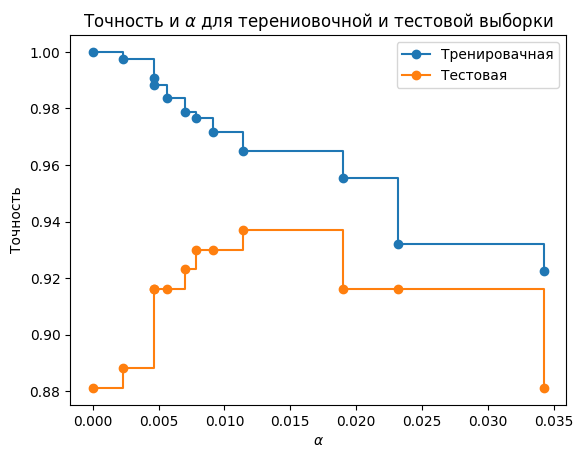

In [6]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("Точность")
ax.set_title("Точность и $\\alpha$ для терениовочной и тестовой выборки")
ax.plot(ccp_alphas, train_scores, marker="o", label="Тренировачная", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="Тестовая", drawstyle="steps-post")
ax.legend()
plt.show()

#### **ISLR**

Проведем на `python` эксперимент аналогичный представленному в [1]. В источнике не указано подробно как эксперимент проводился, потому проведу его как чуствую:

- Все следующие шаги формируются в множество прогонов:
    - Формируем train/test;
    - Вычиляем эффективные $\alpha$ для выбранного train;
    - Для всех эффективных $\alpha$:
        - Оциниваем на train/test;
        - Кроссвалидируем на test.

По идее кроссвалидация тут не нужна, потому как прогоны разбиения train/test сами по себе эквиванентны кроссвалидации.

Далее графичеки представим результаты. На следующем графике показана связь точности модели с числом листов. Палочками представлено стандарное отлоенние по различным прогонам.

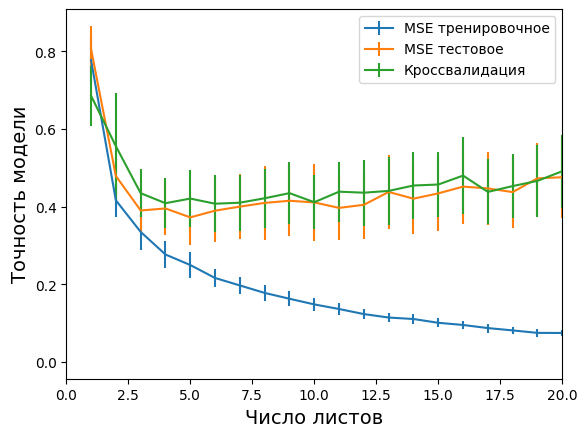

In [81]:
results_frame = pd.read_csv("ISLR_exeriment.csv")

tree_depth_gb = results_frame.groupby("Число листов")

MSE_plots = (
    tree_depth_gb["MSE тренировочное"],
    tree_depth_gb["MSE тестовое"],
    tree_depth_gb["Кроссвалидация"]
)

for MSE in MSE_plots:
    plt.errorbar(tree_depth_gb.groups.keys(), MSE.mean(), MSE.std())

ans = plt.legend([
    "MSE тренировочное",
    "MSE тестовое",
    "Кроссвалидация"
])
plt.xlabel("Число листов", fontsize = 14)
plt.ylabel("Точность модели", fontsize = 14)

ans = plt.xlim([0,20])

Не получается в точности воспроизвести эксперимент из ISLR. И в нашем случае лучшая модель исопльзует 4 листа. Но идея о бесконечном увеличении метрики качества на обучающей выборке понятна.

# Дерево и пропуски

Вроде сказано, что дерево может по прежнему обучаться на тех наборах данных в которых присудствуют пропуски. Рассмотрим подробнее как это работатет.

В следующей ячейке создан набор данных на задачу классификации , в котром пропущено 100 значений для одной из переменных.

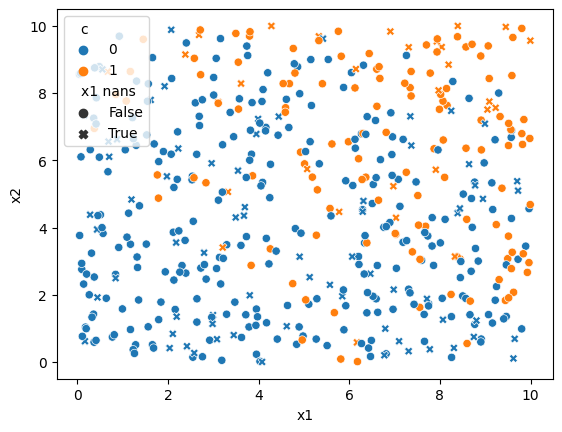

In [2]:
np.random.seed(20)

d = pd.DataFrame({
    "x1" : np.random.uniform(0, 10, 500),
    "x2" : np.random.uniform(0, 10, 500)
})

r = d["x1"] + d["x2"]

d["c"] = ((r - r.min())/(r.max() - r.min())).apply(
    lambda prob: np.random.choice([1,0], p = [prob**2, 1-(prob**2)])
)

d["x1 nans"] = d["x1"]
d.loc[d.sample(100).index, "x1 nans"] = np.NaN

ans = sns.scatterplot(data=d, x="x1", y="x2", hue="c", style=d["x1 nans"].isna())

Попробуем, такой набор данных скормить дереву и посмотрим, какое решение оно предложит:

В общем, это не сработало - выдает ошибку оценщик.